## Questions to Answer
1. Does Filtering on noise estimates worsen imbalance? Before vs after IR for CLNI, Two-stage ensemble
2. Avg. noise likelihood of minority vs majority class?
3. Ratio of 0->1 & 1->0 noise types vs ratio of noisy samples identified in each class. With oracle access to no of actual, total no. of noisy samples 

In [2]:
import numpy as np,os
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef, precision_recall_curve, auc, accuracy_score, precision_score, recall_score
import seaborn as sns,matplotlib.pyplot as plt

from library.utils import evaluate, read_data
from library.cleaners import kDN, ih_prob

C:\Users\Shihab\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Notes
+ Using `kDN(K=5)`: In `25/32` datasets, no of samples with NP noise (Bug class in noisy dataset but actually Clean) has been overestimated. Consequently PN has been underestimated. This shows minority class gets disproportionately affected.
    + For `ih_prob`: that number is `23/32`
+ In terms of avg. probability of being noisy: samples in Bug class (of noisy data version) have vastly hugher value than clean ones. On further avg on 32 datasets, `.702 vs .074`, almost 10 times higher.

In [3]:
DATASETS = ['groovy-1_5_7.csv','jruby-1.4.0.csv','lucene-2.9.0.csv','jruby-1.7.0.preview1.csv','groovy-1_6_BETA_1.csv',
        'derby-10.2.1.6.csv','wicket-1.5.3.csv','camel-2.9.0.csv','camel-1.4.0.csv','activemq-5.8.0.csv']
DATASETS = [f for f in os.listdir("JIRA/") if 'csv' in f]
len(DATASETS)

32

In [4]:
def ih():
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    rf = RandomForestClassifier(n_estimators=50,n_jobs=4)

    probabilities = np.zeros(Y.shape[0], dtype=float)
    for train_index, test_index in skf.split(X,Y):
        rf.fit(X[train_index], Y[train_index])
        probs = rf.predict_proba(X[test_index])
        probabilities[test_index] = probs[range(len(test_index)), Y[test_index]]

    hardness = 1 - probabilities

In [6]:
df = pd.DataFrame(index=DATASETS,columns=['PN','ePN','NP','eNP','bug-ih','clean-ih'])
for d in DATASETS:
    X,y_noisy,y_real = read_data(d,True)
    PN = y_noisy[y_real==1]==0   #So, really 1(P), but now 0(N)
    NP = y_noisy[y_real==0]==1   #So, really 0(N), but now 1(P)
    assert PN.sum()+NP.sum()==(y_noisy!=y_real).sum()
    print(f"PN {PN.sum()},NP {NP.sum()}")
    ne = kDN(X,y_noisy,K=5)
    
    avg_bug,avg_clean = ne[y_noisy==1].mean(),ne[y_noisy==0].mean()  #avg_bug: avg noise probs of those labelled Buggy in Noisy dataset
    actual_total = (y_noisy!=y_real).sum()
    nidx = np.argsort(ne)[-actual_total:]
    eNP = y_noisy[nidx]==1
    ePN = y_noisy[nidx]==0
    print(f"ePN {ePN.sum()},eNP {eNP.sum()}")
    print(f"Avg, Bug:{avg_bug:.3f}, Clean:{avg_clean:.3f}")
    print()
    df.loc[d,:] = [x.sum() for x in [PN,ePN,NP,eNP]] + [avg_bug,avg_clean]
    
df.to_csv('why_filters_bad_kDN.csv')

activemq-5.0.0.csv noise:0.139, imb:21.976,82,1802, Shape:(1884, 65)
PN 236,NP 25
ePN 182,eNP 79
Avg, Bug:0.773, Clean:0.033

activemq-5.1.0.csv noise:0.083, imb:13.173,139,1831, Shape:(1970, 65)
PN 89,NP 74
ePN 55,eNP 108
Avg, Bug:0.696, Clean:0.051

activemq-5.2.0.csv noise:0.113, imb:12.247,154,1886, Shape:(2040, 65)
PN 148,NP 83
ePN 91,eNP 140
Avg, Bug:0.761, Clean:0.058

activemq-5.3.0.csv noise:0.094, imb:15.669,142,2225, Shape:(2367, 65)
PN 169,NP 53
ePN 88,eNP 134
Avg, Bug:0.782, Clean:0.042

activemq-5.8.0.csv noise:0.058, imb:15.847,203,3217, Shape:(3420, 65)
PN 100,NP 97
ePN 25,eNP 172
Avg, Bug:0.790, Clean:0.045

camel-1.4.0.csv noise:0.281, imb:3.174,363,1152, Shape:(1515, 65)
PN 174,NP 252
ePN 161,eNP 265
Avg, Bug:0.624, Clean:0.180

camel-2.10.0.csv noise:0.053, imb:24.447,311,7603, Shape:(7914, 65)
PN 169,NP 250
ePN 130,eNP 289
Avg, Bug:0.810, Clean:0.031

camel-2.11.0.csv noise:0.024, imb:43.230,200,8646, Shape:(8846, 65)
PN 100,NP 108
ePN 26,eNP 182
Avg, Bug:0.844, Cl

In [ ]:
df

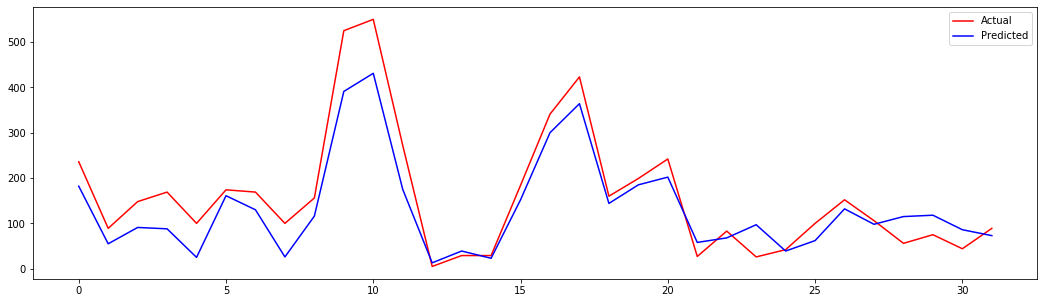

In [7]:
plt.figure(figsize=(18,5))
plt.plot(range(len(DATASETS)),df['PN'],c='r',label='Actual');
plt.plot(range(len(DATASETS)),df['ePN'],c='b',label='Predicted');
plt.legend();

In [8]:
(df['ePN']>df['PN']).sum(),(df['eNP']>df['NP']).sum()

(7, 25)

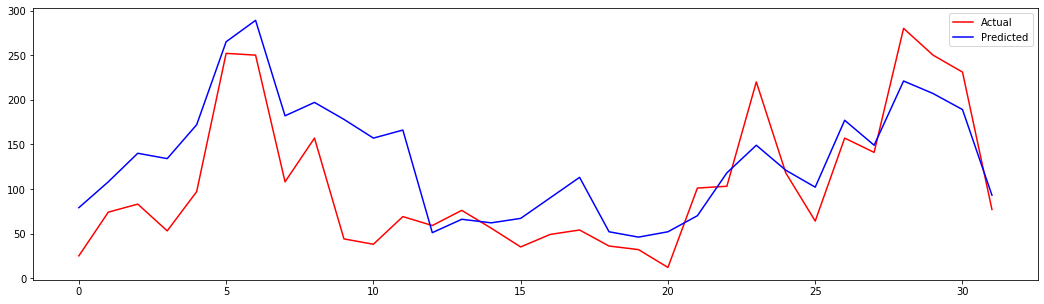

In [9]:
plt.figure(figsize=(18,5))
plt.plot(range(len(DATASETS)),df['NP'],c='r',label='Actual');
plt.plot(range(len(DATASETS)),df['eNP'],c='b',label='Predicted');
plt.legend();

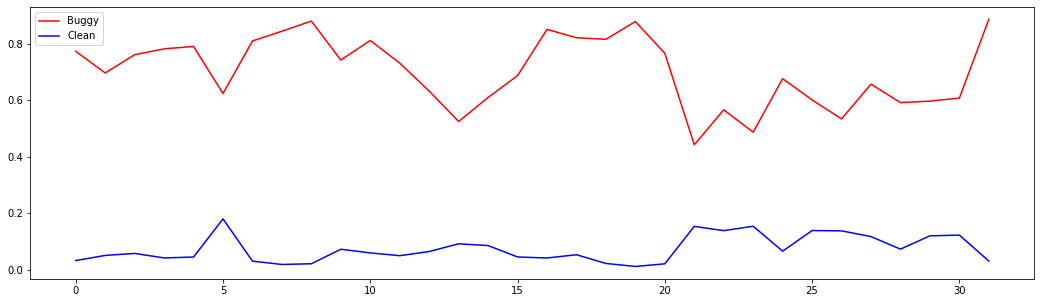

In [11]:
plt.figure(figsize=(18,5))
plt.plot(range(len(DATASETS)),df['bug-ih'],c='r',label='Buggy');
plt.plot(range(len(DATASETS)),df['clean-ih'],c='b',label='Clean');
plt.legend();

In [12]:
df['bug-ih'].mean(),df['clean-ih'].mean()

(0.7023411611877398, 0.07362090891121963)

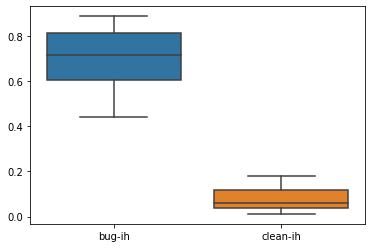

In [14]:
sns.boxplot(data=df[['bug-ih','clean-ih']]);

In [ ]:
ih = df.copy()

In [ ]:
kdn = df.copy()

In [ ]:
a = kdn[['avg-bug','avg-clean']].assign(detect='kDN')
b = ih[['avg-bug','avg-clean']].assign(detect='IH')

In [ ]:
tmp = pd.concat([a,b],axis=0)

In [ ]:
tt = pd.melt(tmp,id_vars=['detect'])
tt

In [ ]:
tt.columns = ['detector','Class','MCC']

In [ ]:
plt.figure(figsize=(6,5));
f = sns.boxplot(x='Class',y='MCC',data=tt,hue='detector');

In [ ]:
f.get_figure().savefig("figures/noise_estimates.svg",format='svg');

## Impact on Classification performance
So, both noise detectors discriminate against minority Bug class. But when we incorporate this noise estimates into this imbalanced classification setting, how much does this actually hurt classification performance? Is balancing first better? `Balancing->Filtering` vs `Filtering->Balancing`

In [ ]:
from collections import defaultdict
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedBaggingClassifier, RUSBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, TomekLinks
from imblearn.pipeline import Pipeline

from library.cleaners import FilteringEstimator

In [ ]:
def evaluateFilter(clf,X,y_noisy,y_real,cv,scorers):
    scores = defaultdict(list)
    to_keep = (y_noisy==y_real).sum()
    for train_id, test_id in cv.split(X,y_real):  #vs y_noisy, to solve no-pos-label-in-test-set bug     
        try:
            clf = clf.fit(X[train_id],y_noisy[train_id],to_keep=to_keep)
            probs = clf.predict_proba(X[test_id])
            assert probs.shape[1]==2
        except (ValueError,AssertionError) as e: 
            #assert str(e).startswith("Expected n_neighbors") or str(e).startswith("The target"),f"Some different Error:{str(e)}"
            for func in scorers:
                scores[func.__name__].append(0)
            print("ERROR")
            continue
        labels = np.argmax(probs,axis=1)
        for func in scorers:
            yp = probs[:,1]
            try:
                func([0,1,1],[.2,.6,.7])
                yp = probs[:,1]
            except ValueError as e:
                yp = labels
            scores[func.__name__].append(func(y_real[test_id],yp))
    for func in scorers:
        scores[func.__name__] = np.array(scores[func.__name__])
    return scores

In [ ]:
imbs = {
    'smote': SMOTE(k_neighbors=5),
    'rus': RandomUnderSampler('not minority'),
    'wilson':EditedNearestNeighbours(n_neighbors=5),  #Default was 3
    'tomek': TomekLinks(),
}
clfs = {
    'dt': DecisionTreeClassifier(max_depth=20),
    'lr': LogisticRegression(solver='lbfgs',max_iter=1000),
    'nb': GaussianNB(),
    'knn': KNeighborsClassifier(n_neighbors=5),
    'rf': RandomForestClassifier(n_estimators=50),
}
ensembles = {
    'rboost_DT': RUSBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),algorithm='SAMME',n_estimators=10),
    'rboost_NB': RUSBoostClassifier(base_estimator=GaussianNB(),algorithm='SAMME',n_estimators=10),
    'bbag_DT': BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=20,max_features='sqrt')),
    'bbag_NB': BalancedBaggingClassifier(base_estimator=GaussianNB()),
}
simples = {
    'LR': LogisticRegression(solver='lbfgs',max_iter=1000),
    'RF': RandomForestClassifier(n_estimators=50)
}

## Filtering -> Balancing

In [ ]:
models = {}
for im,samp in imbs.items():
    for c,clf in clfs.items():
        models[(im,c)] = FilteringEstimator(Pipeline([('samp',samp),('clf',clf)]),kDN,K=5)

for m,ens in ensembles.items():
    models[('ens',m)] = FilteringEstimator(ens,kDN,K=5)
    
for m,clf in simples.items():
    models[('sim',m)] = FilteringEstimator(clf,kDN,K=5)    
    
models.keys(),len(models)

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=None)
def pr_rec_score(y,yp):
    prec, rec, _ = precision_recall_curve(y,yp)
    return auc(rec,prec)
scorers = [matthews_corrcoef,pr_rec_score]

In [ ]:
cols = pd.MultiIndex.from_product([imbs.keys(),clfs.keys(),[f.__name__ for f in scorers]],names=['imb','clf','metric'])
df = pd.DataFrame(index=DATASETS,columns=cols)
df = pd.read_csv("Filtering->Balancing.csv",header=[0,1,2],index_col=0)

In [ ]:
for d in DATASETS:
    X,y_noisy,y_real = read_data(d,stats=True)
    if df.loc[d,:].isna().sum()==0: 
        print(f"Skipping {d}")
        continue
    for k in models:
        print(k)
        r = evaluateFilter(models[k],X,y_noisy,y_real,cv,scorers)
        for f in r:
            df.loc[d,(k[0],k[1],f)] = r[f].mean()
    df.to_csv("Filtering->Balancing.csv")

In [ ]:
df

In [ ]:
from scipy.stats import wilcoxon, friedmanchisquare, rankdata
import scikit_posthocs as sp

In [ ]:
mat = df.drop(columns=['matthews_corrcoef'],axis=1,level=2).droplevel(2,axis=1)
mat.shape

In [ ]:
res = mat.copy()
for d in mat.index:
    res.loc[d] = rankdata(1-mat.loc[d])
res

In [ ]:
res.mean().sort_values()